In [1]:
print("\nRetraining 'in_blink_out' model for subject and modifying 'eye_tracking' data for it.")


Retraining 'in_blink_out' model for subject and modifying 'eye_tracking' data for it.


In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from joblib import load as jload
from joblib import dump as jdump
import pickle
import tuning_parameters as tp
import time
import numpy as np
import os

2021-10-25 00:13:45.923755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-25 00:13:45.923777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
R_TRAIN = 0.85
N_EPOCHS = 50
PATIENCE = 10
TRAINABLE_LAYERS = 1
subject_dir = tp.TARGET_FOLDER + f"/{tp.NUMBER}/"
public_model_dir = f"models/in_blink_out/trained/model{tp.IN_BLINK_OUT_MODEL_NUMBER}"
scaler_dir = f"models/in_blink_out/trained/scalers{tp.IN_BLINK_OUT_MODEL_NUMBER}.bin"

In [4]:
print("\nLoading subject data in in_blink_out folder...")
ibo_fol = subject_dir + "in_blink_out data/"
with open(ibo_fol + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(ibo_fol + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(ibo_fol + "y.pickle", "rb") as f:
    y_load = pickle.load(f)
n_smp, frame_height, frame_width = x1_load.shape[:-1]
print(f"Sapmles number: {n_smp}")
time.sleep(2)


Loading subject data in in_blink_out folder...
Sapmles number: 900


[-3.07070363 -0.0705313   0.37098512  2.52360818  2.54080101 68.80416954
  0.57000834  0.51454192  0.45860058  0.52025151]
1


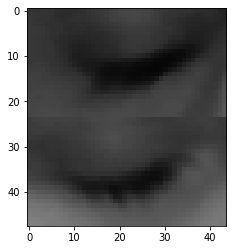

In [9]:
# Displaying data
import matplotlib.pyplot as plt

SAMPLE_NUMBER = 301
print(x2_load[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_load[SAMPLE_NUMBER].reshape((frame_height, frame_width)), cmap="gray", vmin=0, vmax=255)
plt.show()

In [10]:
print("\nNormalizing data...")
x2_chs_inp = x2_load[:, tp.CHOSEN_INPUTS]
scalers = jload(scaler_dir)
x1_scaler, x2_scaler = scalers
x1 = x1_load / x1_scaler
x2 = x2_scaler.transform(x2_chs_inp)
jdump(scalers, subject_dir + "scalers_in_blink_out.bin")
time.sleep(2)


Normalizing data...


/home/mostafa/Projects/EyeTracker/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [11]:
print("\nShuffling data...")
x1_shf, x2_shf, y_shf = shuffle(x1, x2, y_load)
time.sleep(2)


Shuffling data...


In [12]:
print("\nSplitting data to train and test...")
n_train = int(R_TRAIN * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_train = y_shf[:n_train]
y_test = y_shf[n_train:]
print("Data shapes:")
print(x1_train.shape, x1_test.shape, x2_train.shape, x2_test.shape,
      y_train.shape, y_test.shape)
time.sleep(2)


Splitting data to train and test...
Data shapes:
(765, 48, 44, 1) (135, 48, 44, 1) (765, 7) (135, 7) (765,) (135,)


In [19]:
y_train_ctg = to_categorical(y_train)
y_test_ctg = to_categorical(y_test)

x_train = [x1_train, x2_train]
x_test = [x1_test, x2_test]

In [14]:
print("\nLoading 'eye tracking' model...")
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)
model = load_model(public_model_dir)
time.sleep(2)


Loading 'eye tracking' model...


2021-10-25 00:19:47.012267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 00:19:47.013581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-25 00:19:47.013842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-25 00:19:47.014061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-25 00:19:47.014271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [10]:
# for layer in model.layers[:-TRAINABLE_LAYERS]:
#     layer.trainable = False
# print("\nModel summary:")
# print(model.summary())
# time.sleep(2)


Model summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
______________________________________________________________________________

In [15]:
print("\nRetraining the model...")
results = model.fit(x_train,
                    y_train_ctg,
                    validation_data=(x_test, y_test_ctg),
                    epochs=N_EPOCHS,
                    callbacks=cb)
print("End of retraining...")
time.sleep(2)


Retraining the model...
Epoch 1/50


2021-10-25 00:20:03.886154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


24/24 [==============================] - 2s 45ms/step - loss: 0.6899 - acc: 0.8418 - val_loss: 0.2906 - val_acc: 0.8889
Epoch 2/50
24/24 [==============================] - 1s 37ms/step - loss: 0.1986 - acc: 0.9268 - val_loss: 0.1283 - val_acc: 0.9333
Epoch 3/50
24/24 [==============================] - 1s 38ms/step - loss: 0.1093 - acc: 0.9647 - val_loss: 0.0859 - val_acc: 0.9630
Epoch 4/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0652 - acc: 0.9765 - val_loss: 0.0582 - val_acc: 0.9778
Epoch 5/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0389 - acc: 0.9843 - val_loss: 0.0539 - val_acc: 0.9852
Epoch 6/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0264 - acc: 0.9948 - val_loss: 0.0549 - val_acc: 0.9778
Epoch 7/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0175 - acc: 0.9974 - val_loss: 0.0245 - val_acc: 0.9926
Epoch 8/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0105 - acc: 0.9974 

In [17]:
model.save(subject_dir + "model_in_blink_out")

2021-10-25 00:22:04.582455: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: subjects/1/model_in_blink_out/assets


In [20]:
yhat_train = model.predict(x_train).argmax(1)
yhat_test = model.predict(x_test).argmax(1)

Test
0
0


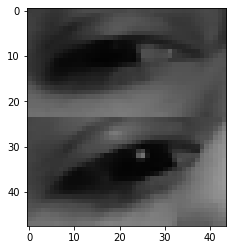

In [29]:
SAMPLE_NUMBER = 8
print("Test")
print(y_test[SAMPLE_NUMBER])
print(yhat_test[SAMPLE_NUMBER])
plt.imshow(
    (x1_test[SAMPLE_NUMBER].reshape((frame_height, frame_width)) * 255)
    .astype(np.uint8),
    cmap="gray",
    vmin=0,
    vmax=255
    )
plt.show()

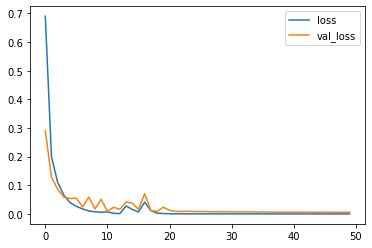

In [30]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

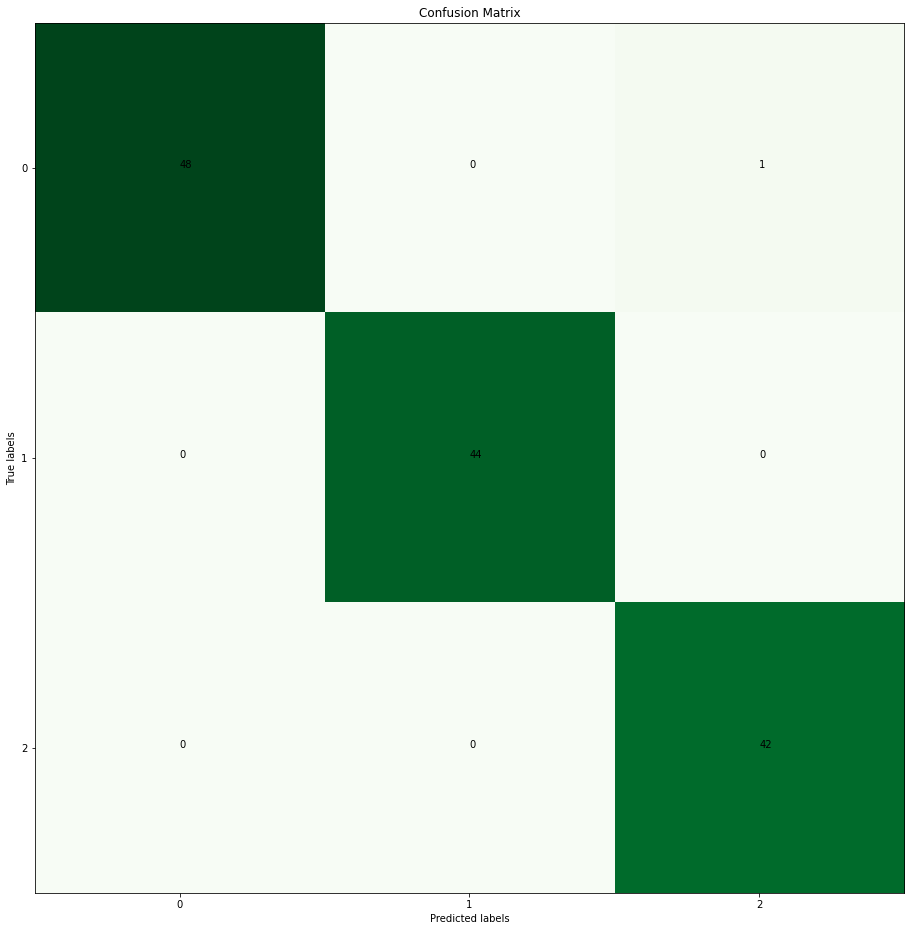

In [31]:
from sklearn.metrics import confusion_matrix

n_class = y_train_ctg.shape[1]
cm_test = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(16,16))
plt.imshow(cm_test, cmap=plt.cm.Greens)
class_arr = np.arange(n_class)
plt.xticks(class_arr)
plt.yticks(class_arr)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(n_class):
    for j in range(n_class):
        plt.text(i, j, cm_test[j][i])